# Observables from twopoppy

You need to **clone** (not download) the `twopoppy code`:

    git clone https://github.com/birnstiel/two-pop-py
    
Then go in the repository and install it e.g. with

    pip install -e .

All the imports and setup stuff:

In [1]:
from planck_B_nu import planck_B_nu
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from astropy import units as u
from scipy.integrate import cumtrapz

import twopoppy
from twopoppy.wrapper import model_wrapper
from twopoppy.args import args
from twopoppy import model

c_light = c.c.cgs.value
au = u.au.to('cm')
pc = u.pc.to('cm')
M_sun = c.M_sun.cgs.value
year = u.year.to('s')
arcsec_sq = (u.arcsec**2).to(u.sr)  # arcsec**2 in steradian

%matplotlib inline
plt.style.use({'figure.dpi': 200})

Get some data

In [2]:
a = args()
#print(a)
res = model_wrapper(a)


-------------------------------------------------------------------------------
         _____ _    _  _____       ______ ___________      ________   __
        |_   _| |  | ||  _  |      | ___ \  _  | ___ \     | ___ \ \ / /
          | | | |  | || | | |______| |_/ / | | | |_/ /_____| |_/ /\ V /
          | | | |/\| || | | |______|  __/| | | |  __/______|  __/  \ /
          | | \  /\  /\ \_/ /      | |   \ \_/ / |         | |     | |
          \_/  \/  \/  \___/       \_|    \___/\_|         \_|     \_/


This script runs a two-population dust model according to Birnstiel, Klahr,
Ercolano, A&A (2012). The output of the code is described in the README.md file.

Available at: https://github.com/birnstiel/two-pop-py

For bug reports, questions, ... contact birnstiel@mpia.de.

Note:
-----

If you use this code in a publication, please cite at least Birnstiel,
Klahr, & Ercolano, A&A (2012)[1], and possibly Birnstiel et al. (ApJL) 2015[2]
if you use the size distribution reconstruction. I

/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))


------------------------------------------------

                    ALL DONE                    

------------------------------------------------


## Load opacity

In [3]:
opacity = np.load('opacity.npz')

k_a = opacity['k_a']
k_s = opacity['k_s']
lam = opacity['lam']
a_opac = opacity['a']
n_lam = len(lam)
rhos = res.args.rhos

In [21]:
lam = lam[2]

Plotting the opacity

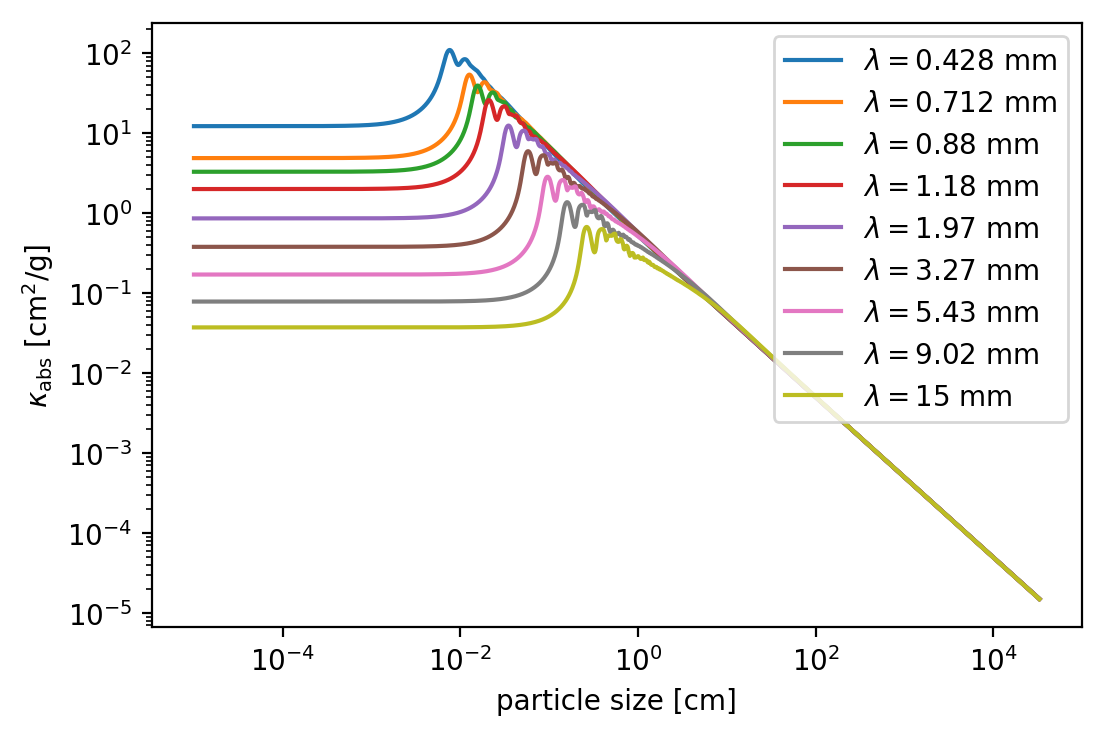

In [4]:
f, ax = plt.subplots()
for ilam in range(n_lam):
    ax.loglog(a_opac, k_a[:, ilam], label='$\lambda = {:.3g}$ mm'.format(10 * lam[ilam]))
ax.legend()
ax.set_xlabel('particle size [cm]')
ax.set_ylabel('$\kappa_\mathrm{abs}$ [cm$^2$/g]');

## Calculate optical depth and emission profiles

Define the function that reconstructs the size distribution

In [5]:
def get_distri(res, it):
    """
    Reconstructs the size distribution of the given simulation at the given
    snapshot index
    
    Arguments:
    ----------
    res : twopoppy.results.results
        twopoppy Results object
        
    it : int
        index of the snapshot in the simulation results
        
    Output:
    -------
    sig_da : array
        the dust surface density on the grid particle size vs. distance to star
        units are in g/cm^2
    
    a_max : array
        maximum particle size in cm as a function of radius (on the simulations radius grid)
    
    """
    
    if res.T.ndim == 1:
        T = res.T
    else:
        T = res.T[it]
    
    distri = twopoppy.distribution_reconstruction.reconstruct_size_distribution(
        res.x,
        res.a,
        res.timesteps[it],
        res.sigma_g[it],
        res.sigma_d[it],
        res.alpha * np.ones_like(res.x),
        res.args.rhos,
        T,
        res.args.mstar,
        res.args.vfrag,
        estick=res.args.estick,
        a_0=res.args.a0)

    return distri[:2]

Define the function that will do all the work for us:

- interpolate the opacity on the particle size grid provided by the simulation itself
- calculate the size distribution and from that
- calculate optical depth, intensity profiles and from those
- r_eff and fluxes

In [8]:
def get_results(res, time, lam, a_opac, k_a, distance=140 * pc, flux_fraction=0.68):
    """
    Calculates the radial profiles of the (vertical) optical depth and the intensity for a given simulation
    at a given time (using the closest simulation snapshot).
    
    Arguments:
    ----------
    
    res : twopoppy.results.results
        twopoppy simulation results object
        
    time : float
        time at which to calculate the results [s]
        
    lam : array
        wavelengths at which to calculate the results [cm]
        
    a_opac : array
        particle size grid on which the opacities are defined [cm]
        
    k_a : array
        absorption opacity as function of wavelength (grid lam) and
        particle size (grid a_opac) [cm^2/g]
        
    Keywords:
    ---------
    
    distance : float
        distance to source [cm]
        
    flux_fraction : float
        at which fraction of the total flux the effective radius is defined [-]
        
    Output:
    -------
    
    rf : array
        effective radii for every wavelength [cm]
    
    flux_t : array
        integrated flux for every wavelength [Jy]
        
    tau,Inu : array
        optical depth and intensity profiles at every wavelength [-, Jy/arcsec**2]
        
    sig_da, : array
        reconstructed particle size distribution on grid (res.a, res.x)
        
    a_max : array
        maximum particle size [cm]
    """

    # interpolate opacity on the same particle size grid as the size distribution

    kappa = np.array([10.**np.interp(np.log10(res.a), np.log10(a_opac), np.log10(k)) for k in k_a.T]).T

    it = np.abs(res.timesteps - time).argmin()
    
    if res.T.ndim == 1:
        T = res.T
    else:
        T = res.T[it]
    
    # reconstruct the size distribution
    
    sig_da, a_max = get_distri(res, it)

    # calculate planck function at every wavelength and radius

    Bnu = planck_B_nu(c_light / (np.array(lam, ndmin=2).T), np.array(T, ndmin=2))  # shape = (n_lam, n_r)
    
    # calculate optical depth

    tau = (kappa.T[:, :, np.newaxis] * sig_da[np.newaxis, :, :])  # shape = (n_l, n_a, n_r)
    tau = tau.sum(1)  # shape = (n_l, n_r)

    # calculate intensity at every wavelength and radius for this snapshot
    # here the intensity is still in plain CGS units (per sterad)

    intens = Bnu * (1 - np.exp(-tau))

    # calculate the fluxes

    flux = distance**-2 * cumtrapz(2 * np.pi * res.x * intens, x=res.x, axis=1, initial=0)  # integrated flux density
    flux_t = flux[:, -1] / 1e-23  # store the integrated flux density in Jy (sanity check: TW Hya @ 870 micron and 54 parsec is about 1.5 Jy)

    # converted intensity to Jy/arcsec**2

    Inu = intens * arcsec_sq / 1e-23
    
    # interpolate radius whithin which >=68% of the dust mass is
    rf = np.array([np.interp(flux_fraction, _f / _f[-1], res.x) for _f in flux])
    
    return rf[2], flux_t[2], tau, Inu, sig_da, a_max

Now we call the function, passing our selected simulation, the time at which we want the results, and size/wavelength/opacity grids

In [9]:
sample_time = res.timesteps.searchsorted(1e6 * year)

rf, flux_t, tau, Inu, sig_da, a_max = get_results(res, sample_time, lam, a_opac, k_a) 

/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:213: RuntimeWarning: invalid value encountered in sqrt
  a_fr = sig_g / (pi * rho_s) * (b - np.sqrt(b**2 - 4.))
/home/apo/anaconda3/lib/python3.6/site-packages/twopoppy-0.0.0-py3.6.egg/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))


In [11]:
print(flux_t)
print(rf)

0.890067140795
1.51407042031e+15


In [54]:
print(rf)

[  2.05710475e+15   1.66424284e+15   1.51407042e+15   1.33385649e+15
   1.04277908e+15   7.80122331e+14   5.45626612e+14   3.46376201e+14
   2.11715315e+14]


In [55]:
print(sig_da.shape)

(150, 200)


Plot the reconstructed size distribution

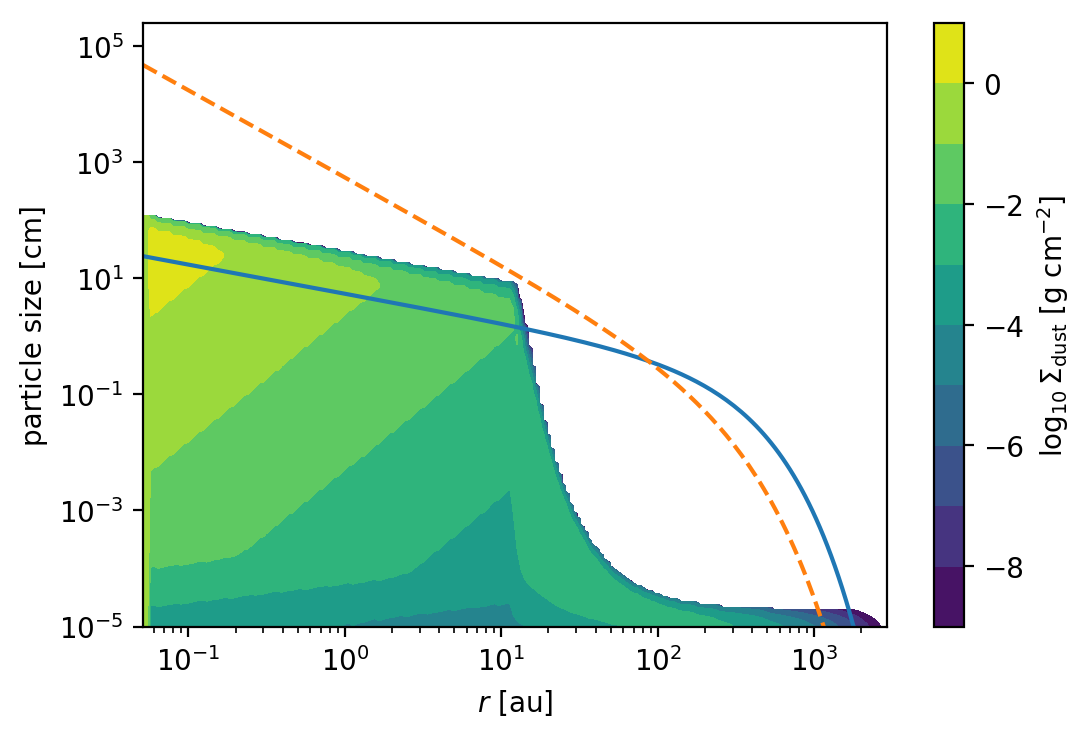

In [30]:
it = np.abs(res.timesteps - sample_time).argmin()
f, ax = plt.subplots()
ymax = np.ceil(np.log10(sig_da.max()))
cc = ax.contourf(res.x / au, res.a, np.log10(sig_da), np.arange(ymax - 10, ymax + 1))
ax.loglog(res.x / au, res.a_fr[it])
ax.loglog(res.x / au, res.a_dr[it], '--')
ax.set_ylim(ymin=res.a[0])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$r$ [au]')
ax.set_ylabel('particle size [cm]')
cb = plt.colorbar(cc)
cb.set_label('$\log_{10}\,\Sigma_\mathrm{dust}$ [g cm$^{-2}$]');

In [31]:
print(it)

0


## Plot the emission profiles

In [43]:
Inu

array([[  6.35404772e+01,   6.17981430e+01,   6.01030828e+01, ...,
          5.84380473e-09,   2.63081362e-09,   1.13624344e-09],
       [  6.35404772e+01,   6.17981430e+01,   6.01030828e+01, ...,
          2.32973754e-09,   1.04882102e-09,   4.52983827e-10],
       [  6.35404772e+01,   6.17981430e+01,   6.01030828e+01, ...,
          1.57179341e-09,   7.07603289e-10,   3.05612536e-10],
       ..., 
       [  6.35404772e+01,   6.17981430e+01,   6.01030828e+01, ...,
          8.15527776e-11,   3.67141144e-11,   1.58567588e-11],
       [  6.35404754e+01,   6.17981387e+01,   6.01029701e+01, ...,
          3.74557496e-11,   1.68621413e-11,   7.28273246e-12],
       [  6.35314340e+01,   6.17840113e+01,   6.00874910e+01, ...,
          1.77967442e-11,   8.01188663e-12,   3.46031428e-12]])

Text(0.5,0,'log $F_\\nu$ [mJy]')

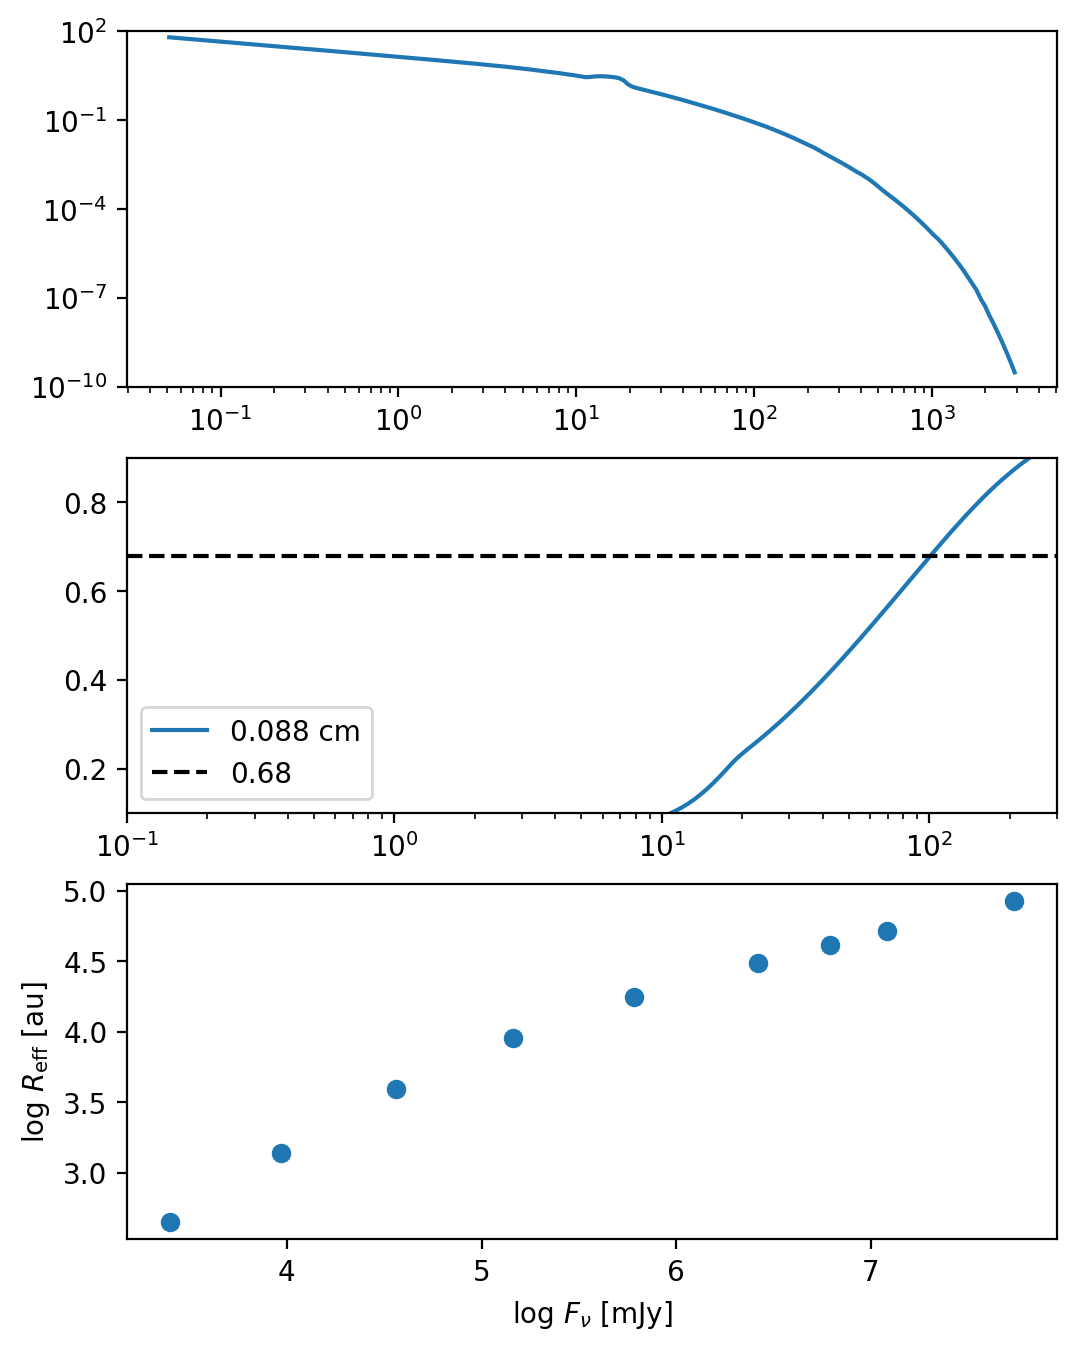

In [42]:
f, ax = plt.subplots(3, 1, figsize=(6, 8))
l, = ax[0].loglog(res.x / au, Inu[2])

cum = cumtrapz(2 * np.pi * res.x * Inu[2], x=res.x, initial=1e-10)
cum = cum / cum[-1]
ax[1].semilogx(res.x / au, cum, color=l.get_color(), label='{:.3g} cm'.format(lam))

ax[1].axhline(0.68, c='k', ls='--', label='0.68') 
    
ax[0].set_ylim(1e-10, 1e2)
ax[1].set_ylim(0.1, 0.9)
ax[1].set_xlim(1e-1, 3e2)
ax[1].legend();
ax[2].scatter(np.log(flux_t * 1e3),np.log(rf / au))
#ax[2].set_ylim(0, 4)
#ax[2].set_xlim(-3, 5)
ax[2].set_ylabel(r'log $R_\mathrm{eff}$ [au]')
ax[2].set_xlabel(r'log $F_\nu$ [mJy]')

TypeError: object of type 'numpy.float64' has no len()

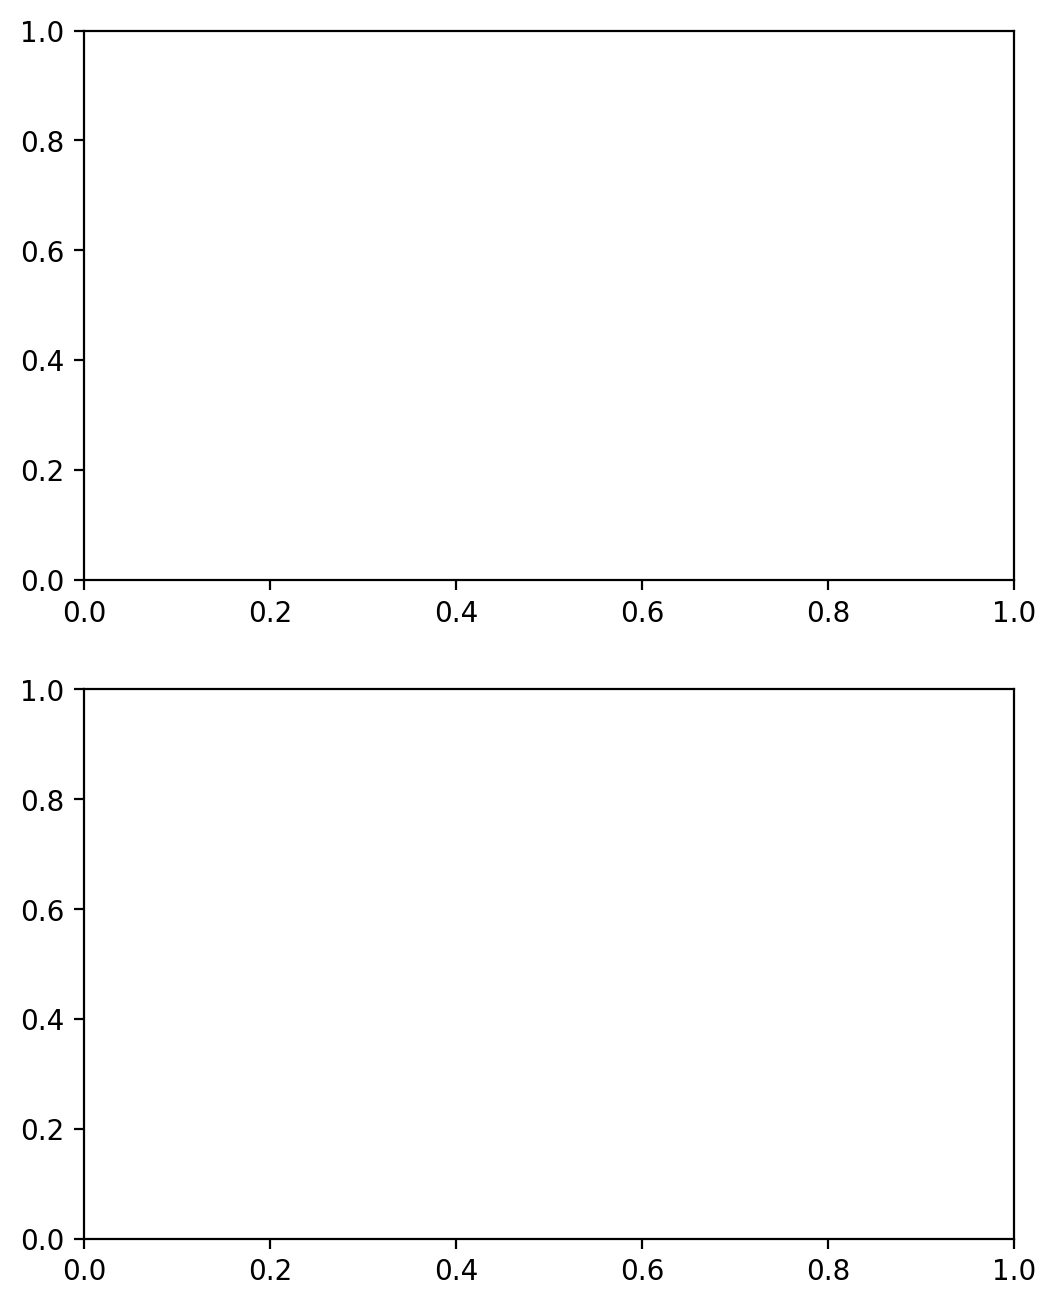

In [32]:
f, ax = plt.subplots(2, 1, figsize=(6, 8))

for i_lam in range(len(lam)):

    l, = ax[0].loglog(res.x / au, Inu[i_lam])

    cum = cumtrapz(2 * np.pi * res.x * Inu[i_lam], x=res.x, initial=1e-10)
    cum = cum / cum[-1]
    ax[1].semilogx(res.x / au, cum, color=l.get_color(), label='{:.3g} cm'.format(lam[i_lam]))

ax[1].axhline(0.68, c='k', ls='--', label='0.68') 
    
ax[0].set_ylim(1e-10, 1e2)
ax[1].set_ylim(0.1, 0.9)
ax[1].set_xlim(1e-1, 3e2)
ax[1].legend();

## Plot the spectral dependence of $r_\mathrm{eff}$ and the flux

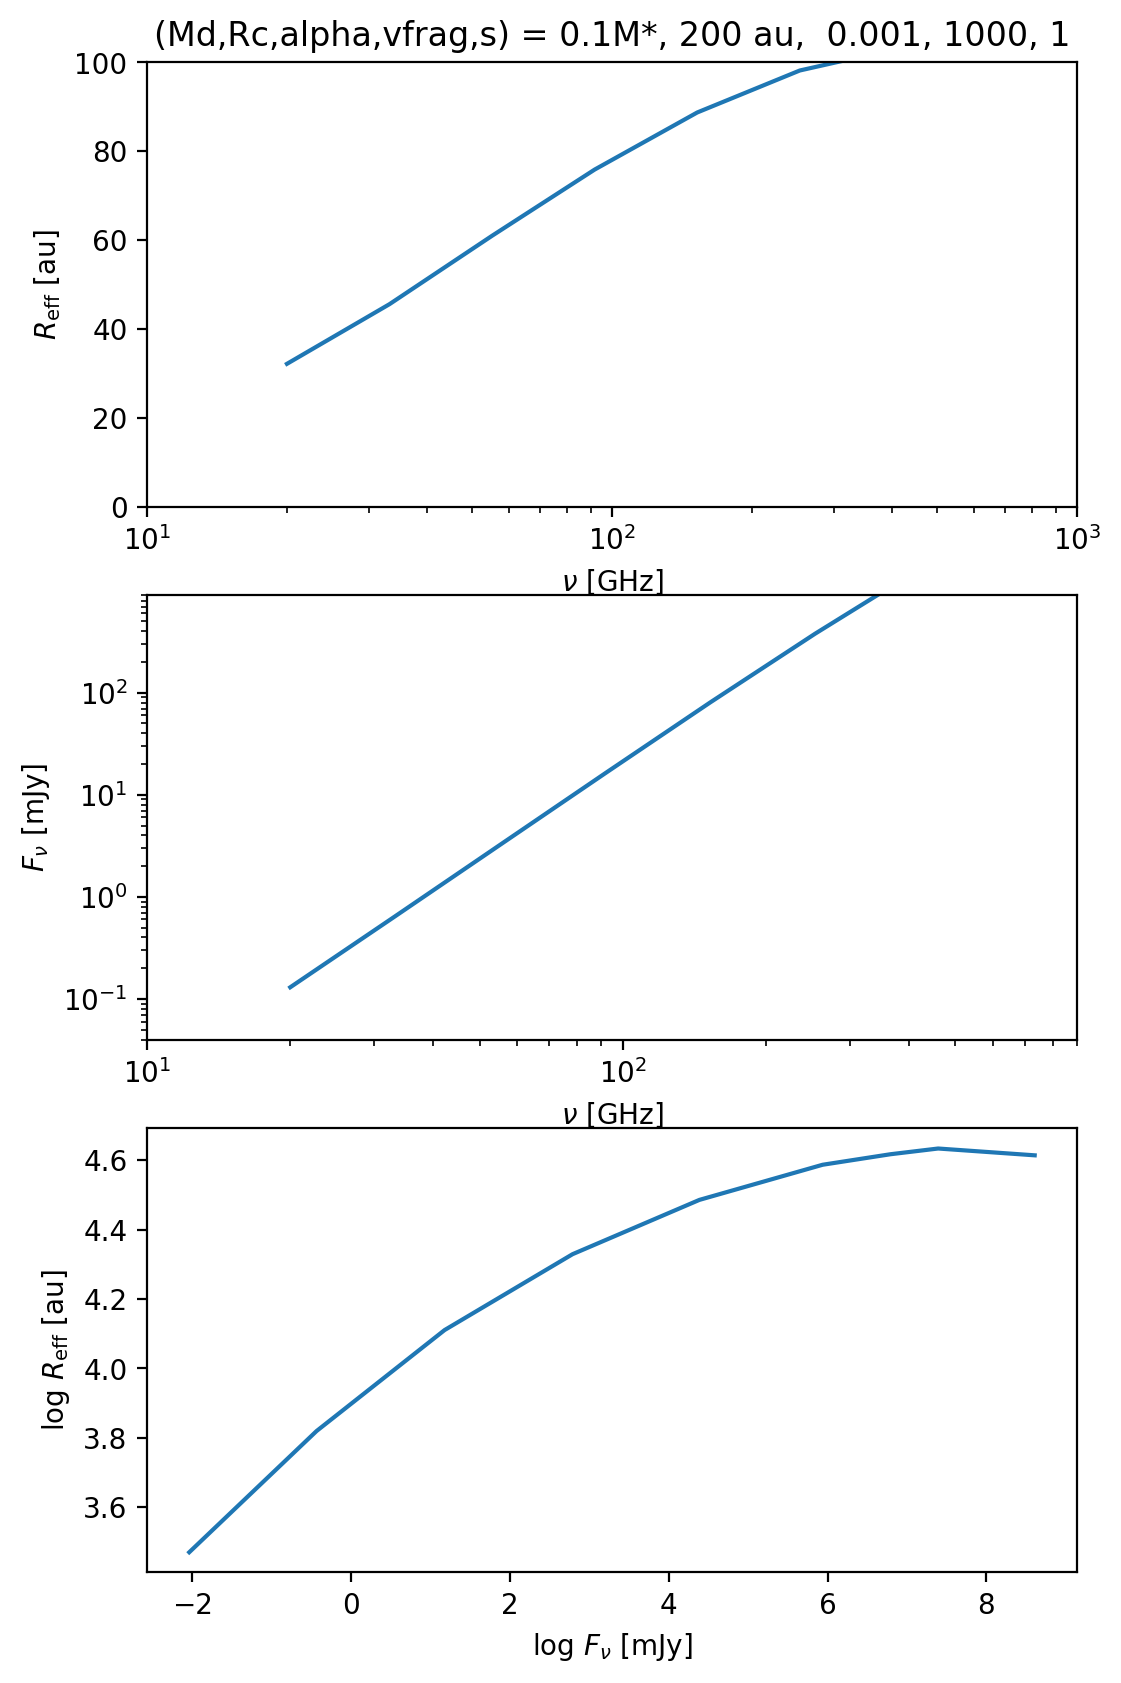

In [12]:
f, ax = plt.subplots(3, 1, figsize=(6, 10))
ax[0].semilogx(c_light / lam / 1e9, rf / au)
ax[0].set_ylim(0, 100)
ax[0].set_xlim(10, 1000)
ax[0].set_xlabel(r'$\nu$ [GHz]')
ax[0].set_ylabel(r'$R_\mathrm{eff}$ [au]')
ax[1].loglog(c_light / lam / 1e9, flux_t * 1e3)
ax[1].set_ylim(4e-2, 9e2)
ax[1].set_xlim(10, 9e2)
ax[1].set_xlabel(r'$\nu$ [GHz]')
ax[1].set_ylabel(r'$F_\nu$ [mJy]')
ax[2].plot(np.log(flux_t * 1e3),np.log(rf / au))
#ax[2].set_ylim(0, 4)
#ax[2].set_xlim(-3, 1)
ax[2].set_ylabel(r'log $R_\mathrm{eff}$ [au]')
ax[2].set_xlabel(r'log $F_\nu$ [mJy]')
ax[0].set_title('(Md,Rc,alpha,vfrag,s) = {:.4g}M*, {:.4g} au,  {:.4g}, {:.4g}, {:.4g}'.format(res.args.mdisk / res.args.mstar, res.args.rc / au, res.args.alpha, res.args.vfrag, res.args.estick))
f.savefig('fig1.pdf')